In [1]:
import time
import pickle
import itertools
from joblib import dump, load
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import os
import PIL
from PIL import Image, ImageFont, ImageDraw, ImageOps, ImageEnhance, ImageFilter

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten, Add, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications import vgg19, vgg16
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization, WeightNormalization
from tensorflow_addons.layers.spectral_normalization import SpectralNormalization
from tensorflow_addons.optimizers import RectifiedAdam as radam


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.__version__

'2.5.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### utils

In [4]:
def allf(d):
    for root, dirs, files in os.walk(d):  
        for filename in files:
            yield filename

In [5]:
def get_image(path, sz=None):
    img = load_img(path)
#     img = img.resize((width, height), PIL.Image.ANTIALIAS)
    if sz is not None: img = img.crop(sz)
    img = img_to_array(img)
#     return vgg16.preprocess_input(np.float32([img]))[0]
    return img

### Load data

In [6]:
#'samples/' + str(i) + '.jpg'
path = '../val_large'
x = [get_image(path + '/' + f, sz=(0, 0, 400, 400)) for f in itertools.islice(allf(path), 4096)]

In [7]:
yl = [165, 190, 215] #[127, 128, 131, 137, 140, 141, 144, 147, 148, 159, 165, 172, 173, 190, 197, 206, 215, 228]
yf = [get_image('paints/' + str(i) + '.jpg', sz=(0, 0, 600, 480)) for i in yl]
y = []
for i in range(len(x) // len(yf) + 1): y += yf
y = y[:len(x)]
np.random.shuffle(y)

(749, 690, 3)


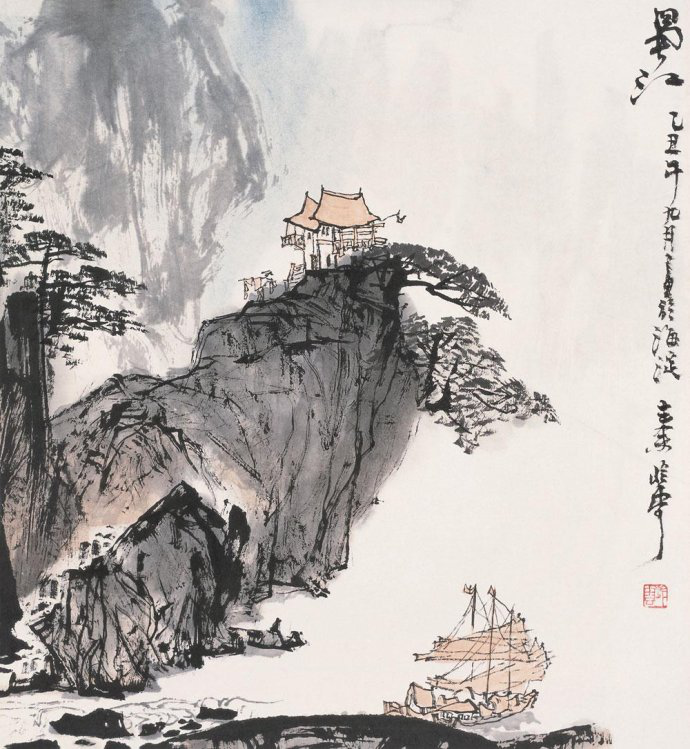

In [8]:
simg = load_img('paints/165.jpg')
h, w = simg.size
c = 1.25
# simg = simg.resize((int(h / c), int(w / c)), PIL.Image.ANTIALIAS)
simgm = simg.transpose(PIL.Image.FLIP_LEFT_RIGHT)
yi = img_to_array(simg)
yim = img_to_array(simg)
y = [yi for i in range(len(x) // 2 + 1)] + [yim for i in range(len(x) // 2 + 1)]
y = y[:len(x)]
np.random.shuffle(y)
print(y[0].shape)
simg

In [9]:
def UpSampling2DBilinear(c, **kwargs):
    def layer(x):
        input_shape = K.shape(x)
        output_shape = (c * input_shape[1], c * input_shape[2])
        return tf.image.resize(x, output_shape, method='bilinear') #, antialias=True)
    return k.layers.Lambda(layer, **kwargs)

def res(x1, layers, kernel=(3,), act='relu', out_act=None, identity=True, pooling='nil', strides=1):
    ConvLayer = k.layers.Conv2D
    MaxPoolingLayer = k.layers.MaxPooling2D
    AvePoolingLayer = k.layers.AveragePooling2D
    GlobalPoolingLayer = k.layers.GlobalAveragePooling2D
    GlobalMaxLayer = k.layers.GlobalMaxPooling2D
    normalizer = InstanceNormalization #BatchNormalization
    param = {} #{"gamma_initializer" :'zeros'}
    if out_act == None: out_act = act

    if pooling == 'up': x1 = k.layers.UpSampling2D(2)(x1)
    elif pooling == 'bi': x1 = UpSampling2DBilinear(2)(x1)
        
    c1 = x1
    
    c1 = ConvLayer(layers , kernel_size=kernel, strides=strides, padding='same')(c1)        
    c1 = normalizer(**param)(c1)

    o1 = x1
    if identity == False or strides > 1:
        if strides > 1:
            o1 = k.layers.ZeroPadding2D(((0, strides-1), (0, strides-1)))(o1)
            o1 = AvePoolingLayer(strides)(o1)
        o1 = ConvLayer(layers, kernel_size=1, padding='same')(o1)
        o1 = normalizer()(o1) # no gamma, main path

    v1 = k.layers.Add()([c1, o1])
    v1 = k.layers.Activation(out_act)(v1) #final activation

    if pooling == 1 or pooling == 'max': v1 = MaxPoolingLayer(2)(v1)
    elif pooling == 2 or pooling == 'ave': v1 = AvePoolingLayer(2)(v1)
    elif pooling == 'global': v1 = GlobalPoolingLayer()(v1)
        
    return v1

def cna(x, l, kn, strides=1, act='relu'):        
    x = k.layers.Conv2D(l, kernel_size=kn, strides=strides, padding='same')(x)        
    x = InstanceNormalization()(x) #BatchNormalization
    return k.layers.Activation(act)(x)

def ctna(x, l, kn, strides=1, act='relu'):        
    x = k.layers.Conv2DTranspose(l, kernel_size=kn, strides=strides, padding='same')(x)        
    x = InstanceNormalization()(x) #BatchNormalization
    return k.layers.Activation(act)(x)

### res

In [35]:
def lout(md, name):
#     return K.function([md.layers[0].input], [md.get_layer(name=name).output])
    return k.models.Model(md.layers[0].input, md.get_layer(name=name).output)

vgg = vgg16.VGG16(input_shape=(None, None, 3), include_top=False)
for layer in vgg.layers: layer.trainable = False

# lns = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
lns = ['block1_conv1', 'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

style_weights = [400000, 200000, 150000, 70000, 10000]

f_layers = [lout(vgg, ln) for ln in lns]

fmodel = k.models.Model(vgg.input, [vgg.get_layer(name=name).output for name in lns])

In [36]:
# K.clear_session()
shape = (None, None, 3) #(690, 690, 3)

c_inp = Input(shape=shape)
s_inp = Input(shape=shape)

v1 = c_inp
v1 = res(v1, 5, (5, 5), identity=0) # first conv

rs = [16, 32, ]
for l in rs:
    v1 = res(v1, l, (3, 3), strides=2, pooling='nil', identity=0) 
# for l in rs: cna(y_out, l, 3, strides=2)

v1 = res(v1, rs[-1], (3, 3)) # inter

for l in rs[::-1]:
    v1 = res(v1, l, (3, 3), pooling='bi', identity=0) # up
    
v1 = k.layers.Conv2D(3, 7, activation='sigmoid', padding='same')(v1) * 255

encoder = k.models.Model(c_inp, v1)
encoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 5 380         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 5 20          input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, None, None, 5 10          conv2d[0][0]                     
____________________________________________________________________________________________

In [37]:
class gram(k.layers.Layer):
    def g(self, s):
        shape = tf.shape(s)
#     tf.print(K.shape(s))
        s = tf.transpose(s, perm=(2, 0, 1))
        s = K.batch_flatten(s)
        g = K.dot(s, tf.transpose(s)) / tf.square(tf.cast(K.prod(shape), K.floatx()))
        return g    
    
    def call(self, s):
        return K.map_fn(self.g, s)
    
    def compute_output_shape(self, input_shape):
        b, h, w, c = input_shape
        return (b, c, c)

c_features = fmodel(vgg16.preprocess_input(v1))
s_features = fmodel(vgg16.preprocess_input(s_inp))
    
s_losses = []
for w, c, s in zip(style_weights, c_features, s_features):    
    ith_loss = K.mean(K.batch_flatten(K.square(gram()(s) - gram()(c))), axis=-1) * w
    s_losses.append(ith_loss)

style_loss = K.mean(K.batch_flatten(tf.stack(s_losses, axis=1)), axis=-1) * 1600

cm = lout(vgg, 'block5_conv2')
content_loss = K.square(cm(vgg16.preprocess_input(v1)) - cm(vgg16.preprocess_input(c_inp)))
content_loss = K.mean(K.batch_flatten(content_loss), axis=-1) / 1000

b, h, w, c = tf.shape(v1)
var_loss = tf.image.total_variation(v1) / tf.cast(h * w, 'float32') * 0.0001

loss = style_loss + content_loss #+ var_loss

model = k.models.Model([c_inp, s_inp], v1)
model.add_loss(loss)
model.add_metric(content_loss, name='content')
model.add_metric(style_loss, name='style')
model.add_metric(var_loss, name='variation')

### Run

In [ ]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)
    
md_save = ModelCheckpoint('weight.h5', save_best_only=True, monitor='val_loss')
model.compile(optimizer=k.optimizers.Adam(0.003))

his = tf.keras.callbacks.History()
model.fit([np.array(x[:2048]), np.array(y[:2048])], None, verbose=1, epochs=30, callbacks=[md_save, his],
                batch_size=16, validation_split=0.1)

Epoch 1/30
116/116 [==============================] - 95s 701ms/step - loss: 0.7331 - content: 0.4934 - style: 0.2397 - variation: 8.3340e-04 - val_loss: 0.4897 - val_content: 0.4294 - val_style: 0.0603 - val_variation: 9.0459e-04
Epoch 2/30
116/116 [==============================] - 91s 783ms/step - loss: 0.4766 - content: 0.4194 - style: 0.0573 - variation: 0.0012 - val_loss: 0.4147 - val_content: 0.3574 - val_style: 0.0573 - val_variation: 0.0014
Epoch 3/30
116/116 [==============================] - 77s 666ms/step - loss: 0.4062 - content: 0.3541 - style: 0.0521 - variation: 0.0016 - val_loss: 0.3593 - val_content: 0.3053 - val_style: 0.0540 - val_variation: 0.0017
Epoch 4/30
116/116 [==============================] - 75s 649ms/step - loss: 0.3571 - content: 0.3085 - style: 0.0486 - variation: 0.0019 - val_loss: 0.3316 - val_content: 0.2775 - val_style: 0.0541 - val_variation: 0.0019
Epoch 5/30
116/116 [==============================] - 75s 649ms/step - loss: 0.3235 - content: 0.278

Text(0.5, 1.0, 'content loss')

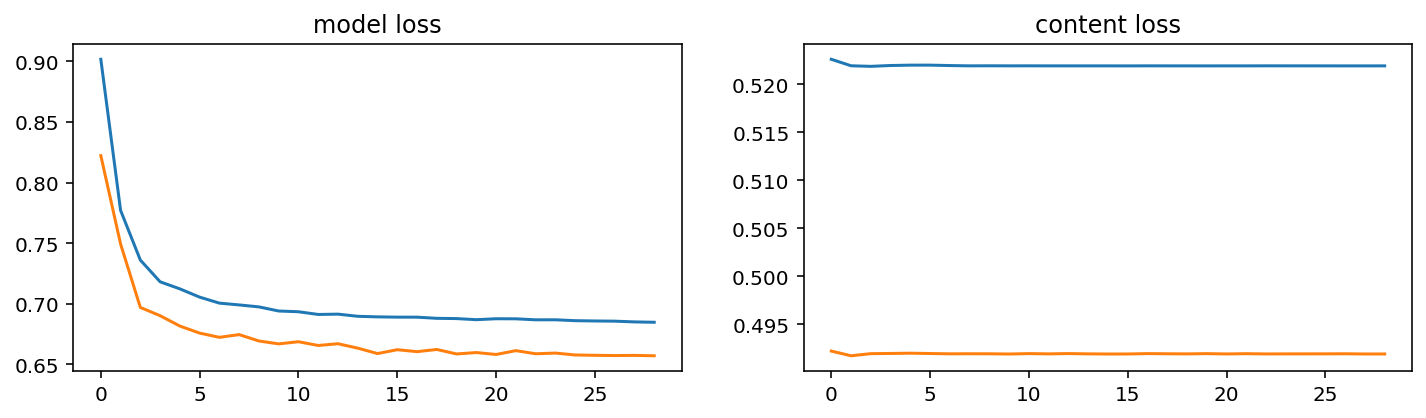

In [19]:
fig = plt.figure(figsize=(12, 3))
logs = his.history

plt.subplot(1,2,1)
plt.plot(his.history['loss'][1:])
plt.plot(his.history['val_loss'][1:])
plt.title('model loss')

plt.subplot(1,2,2)
plt.plot(his.history['content'][1:])
plt.plot(his.history['val_content'][1:])
plt.title('content loss')

# for xi, yi in zip(x, y):    model.train_on_batch([[xi], [yi]], None)

In [25]:
model.load_weights('weight.hd5')

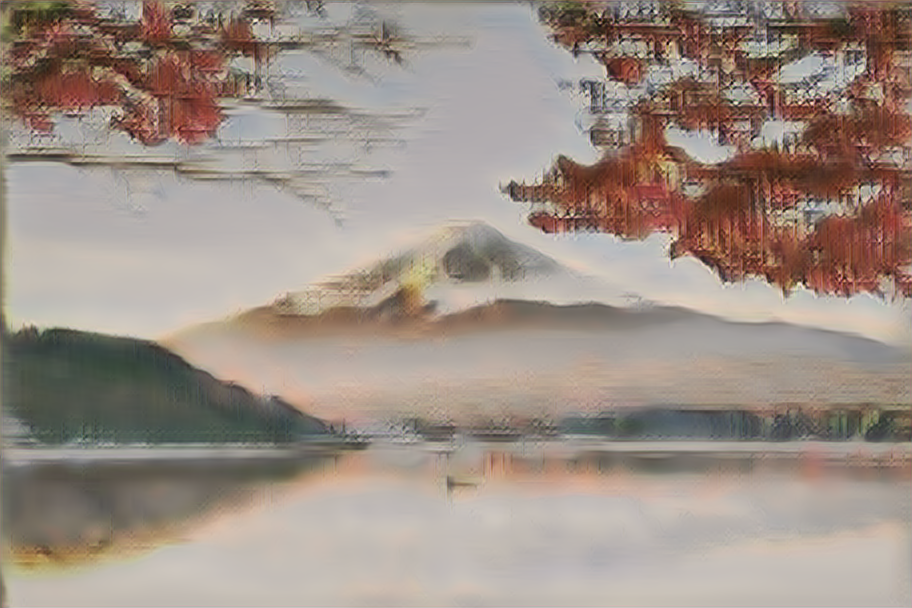

In [30]:
array_to_img(encoder(np.asarray([img_to_array(rl)]))[0])

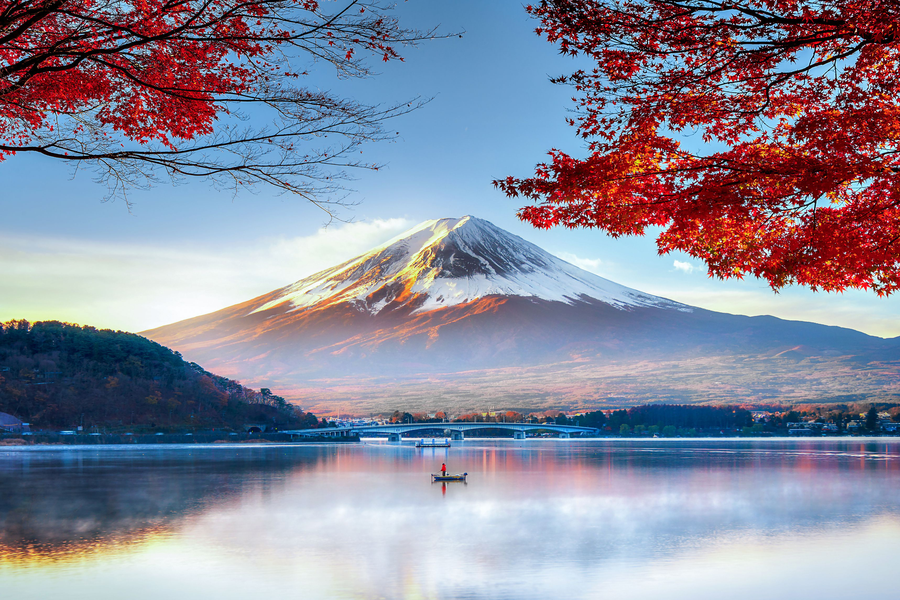

In [22]:
rl = load_img('fuji.jpg').resize((900, 600), PIL.Image.ANTIALIAS)
array_to_img(rl)